# Naive Bayes Classification

In [2]:
!pip install mxnet

%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import mxnet as mx
from mxnet import nd
import numpy as np

# we go over one observation at a time (speed doesn't matter here)
def transform(data, label):
    return (nd.floor(data/128)).astype(np.float32), label.astype(np.float32)
mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test  = mx.gluon.data.vision.MNIST(train=False, transform=transform)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## Naive Bayes Classification

In [3]:
# initialize the counters
xcount = nd.ones((784,10))
ycount = nd.ones((10))

for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:,y] += data.reshape((784))

# using broadcast again for division
py = ycount / ycount.sum()
px = (xcount / ycount.reshape(1,10))

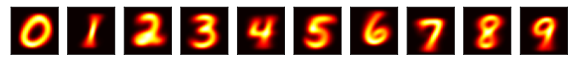

Class probabilities 
[0.09871688 0.11236461 0.09930012 0.10218297 0.09736711 0.09035161
 0.09863356 0.10441593 0.09751708 0.09915014]
<NDArray 10 @cpu(0)>


In [4]:
import matplotlib.pyplot as plt
fig, figarr = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)

plt.show()
print('Class probabilities', py)

### Naive Normalization (without logsum)

In [5]:
# get the first test item
data, label = mnist_test[0]
data = data.reshape((784,1))

# compute the per pixel conditional probabilities
xprob = (px * data + (1-px) * (1-data))
# take the product
xprob = xprob.prod(0) * py
print('Unnormalized Probabilities', xprob)
# and normalize
xprob = xprob / xprob.sum()
print('Normalized Probabilities', xprob)

Unnormalized Probabilities 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<NDArray 10 @cpu(0)>
Normalized Probabilities 
[nan nan nan nan nan nan nan nan nan nan]
<NDArray 10 @cpu(0)>


### Normalization (with logsum)

In [6]:
logpx = nd.log(px)
logpxneg = nd.log(1-px)
logpy = nd.log(py)

def bayespost(data):
    # we need to incorporate the prior probability p(y) since p(y|x) is
    # proportional to p(x|y) p(y)
    logpost = logpy.copy()
    logpost += (logpx * data + logpxneg * (1-data)).sum(0)
    # normalize to prevent overflow or underflow by subtracting the largest
    # value
    logpost -= nd.max(logpost)
    # and compute the softmax using logpx
    post = nd.exp(logpost).asnumpy()
    post /= np.sum(post)
    return post

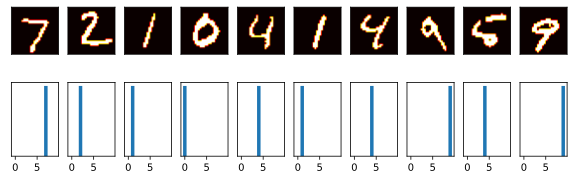

In [7]:
fig, figarr = plt.subplots(2, 10, figsize=(10, 3))
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784,1))
    y = int(label)
    post = bayespost(x)
    figarr[1, ctr].bar(range(10), post)
    figarr[1, ctr].axes.get_yaxis().set_visible(False)
    figarr[0, ctr].imshow(x.reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[0, ctr].axes.get_xaxis().set_visible(False)
    figarr[0, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1
    if ctr == 10: break
plt.show()

### Computing the Accuracy

In [ ]:
# initialize counter
ctr = 0
err = 0

for data, label in mnist_test:
    ctr += 1
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)
    if (post[y] < post.max()):
        err += 1

print('Naive Bayes has an error rate of', err/ctr)